# Public mailing list parsing via Python3 and graph-tool    

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/aparcar/conda/master?filepath=index.ipynb)

Clicking the button below opens the notebook in an interactive Binder session.

This setup describes how to convert a public mailing list into a graphml file for further analysis in tools like Gephi, R or graph-tool. To avoid complicated installations locally the online service Binder is used in combination with JupyterLab.

The following code will parse a public mailing list defined via base_url. All mailbox files found are downloaded automatically as text files. Once downloaded a script iterates over all mails and generates a graph. For easy exploration the graphs is build based on threads. Every thread has a author combined, both represented as nodes. Replies to the thread are edges between the initial thread author and the reply writer.

Using this representation allows quickly filtering of important threads and authors. Authors replying to many threads can be represented by increasing the node size on in or out degree.

## Script walkthrough                                                                                  
The following section describes step by step what the script does.                      

### Importing requirements                                                                                     
This section imports all modules used by the script. Note that graph-tool is specially added in this environment, all other tools are found with every Python3.5+ installation.


In [29]:
from urllib import request
import re
import gzip
from email.header import decode_header
import mailbox
from pathlib import Path
from graph_tool.all import Graph
import graph_tool.all as gt
from math import sqrt

### Defining the mail archive                                                               

The base_url has to point to a public mailing list containing mailbox files, this is the standard view for most public open source mailing lists using the mailing list tool [Mailman](https://list.org/).


In [12]:
base_url = "https://lists.infradead.org/pipermail/openwrt-adm"

The following lines download the overview HTML and find all links to archives.

In [15]:
base_page = request.urlopen(base_url).read().decode("utf-8")
archives = re.findall(r"(\d{4}-.+.txt).gz", base_page)
print(f"Found {len(archives)} mail archives")

Found 44 mail archives


The variables below are for storing values before converting them into a graph.

In [19]:
authors = {}
messages = {}
responses = []
threads = {}
mboxes = []

The graph is initialized and the proberties author, type, date, subject and tag added.

In [23]:
g = Graph()
v_author = g.new_vertex_property("string")
v_type = g.new_vertex_property("string")
v_date = g.new_vertex_property("string")
v_subject = g.new_vertex_property("string")

The main loop iterates reversed over all found archives and downloads them if not found in the current folder. Doing so can be seen as a cache to avoid re-downloading between code changes.

In [24]:
for archive in reversed(archives):
    print(f"Setting up {archive}")
    output = Path(archive)
    if not output.is_file():
        archive_file = request.urlopen(f"{base_url}/{archive}.gz")
        archive_file = gzip.GzipFile(fileobj=archive_file)
        Path(archive).write_bytes(archive_file.read())
    mboxes.append(mailbox.mbox(archive))

Setting up 2016-April.txt
Setting up 2016-May.txt
Setting up 2016-June.txt
Setting up 2016-July.txt
Setting up 2016-August.txt
Setting up 2016-September.txt
Setting up 2016-October.txt
Setting up 2016-November.txt
Setting up 2016-December.txt
Setting up 2017-January.txt
Setting up 2017-February.txt
Setting up 2017-March.txt
Setting up 2017-April.txt
Setting up 2017-May.txt
Setting up 2017-June.txt
Setting up 2017-July.txt
Setting up 2017-August.txt
Setting up 2017-September.txt
Setting up 2017-October.txt
Setting up 2017-November.txt
Setting up 2017-December.txt
Setting up 2018-January.txt
Setting up 2018-February.txt
Setting up 2018-April.txt
Setting up 2018-May.txt
Setting up 2018-June.txt
Setting up 2018-July.txt
Setting up 2018-August.txt
Setting up 2018-September.txt
Setting up 2018-October.txt
Setting up 2018-November.txt
Setting up 2018-December.txt
Setting up 2019-January.txt
Setting up 2019-February.txt
Setting up 2019-March.txt
Setting up 2019-April.txt
Setting up 2019-May.tx

* The loop below iterates over each `mailbox` found, which each contain a single month.
* If the message misses the author or subject, which can happen for spam mails, the message is instantly skipped.
* The author is extracted and reformated to a regular mail address. If the author is not yet added to the graph it is added as a single node and the *author* propery set to the E-Mail address.
* If the mail is **not** a response it is added as a thread to the graph, containing the property *subject* with the mail title as content.
* All messages, also responses are then added to a global message store which is processed in the next code block.

In [25]:
for mbox in mboxes:    
    for mail in reversed(mbox):
        if "From" not in mail or "Subject" not in mail:
            continue

        message_id = mail["Message-ID"]

        from_split = str(mail["From"]).split()
        author = f"{from_split[0]}@{from_split[2]}"

        if author not in authors:
            v_a = g.add_vertex()
            authors[author] = v_a
            v_author[v_a] = author
            v_type[v_a] = "author"

        if not mail.get("In-Reply-To"):
            subject, encoding = decode_header(str(mail["Subject"]).replace("\n", ""))[0]
            if encoding:
                subject = subject.decode("ascii", "ignore")
            subject = str(subject.strip())

            v_m = g.add_vertex()
            v_type[v_m] = "thread"
            threads[message_id] = [v_m, authors[author]]

            g.add_edge(authors[author], v_m)

            v_subject[v_m] = subject

        messages[mail["Message-ID"]] = {
            "reply": mail.get("In-Reply-To"),
            "author": author,
        }

In the following code replies previously stored in the `messages` dict are converted to links between the initial author and the response author. As threads may contain a chain of mails, the function recursily looks for the mail responded to, until the original message with author is found.

In [26]:
for message_id, data in messages.items():
    reply = data["reply"]
    author = data["author"]

    if reply:
        while messages[message_id].get("reply"):
            message_id = messages[message_id].get("reply")
            if message_id not in messages:
                break
        if message_id not in messages:
            continue
        g.add_edge(authors[author], threads[message_id][0])

As a last step the gathered properties are added to the graph `g` and stored as `graphml`. The file is now downloadsable or may be edited further within this notebook.

In [27]:
g.vertex_properties["author"] = v_author
g.vertex_properties["subject"] = v_subject
g.vertex_properties["type"] = v_type
g.save("graph-threads.graphml")

The command below draws the graphs which may take a long time for big graphs. More important nodes are shown slightly bigger. This is just to see the size of the graph, further visual aid depends on the use case.

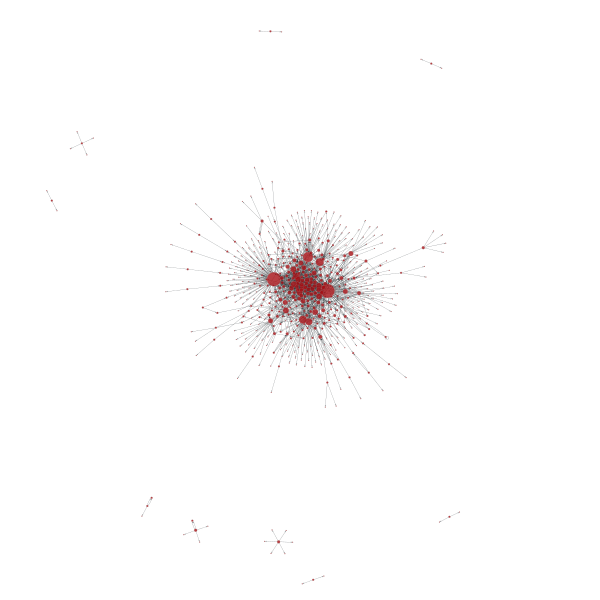

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f554ad25ad0, at 0x7f5548116290>

In [56]:
deg = g.degree_property_map("total")
deg.a = list(map(lambda x: 2 * (sqrt(x) * 0.5 + 0.4), deg.a))
gt.graph_draw(g, vertex_size=deg)
